# Predict Waiting Time at the DMV

## Maximum Likelihood

In this lab we will look at the DMV waiting time example from the class. Let's look at the following situation:

You want to find out how long your mom will have to wait at the DMV. In order to determine the waiting time you stayed at the DMV for a while and measured the waiting time for the customers. You were playing on your phone and so you missed to to measure the exact time. Thus you started to collect the waiting times in the form (5, 0.3), which in this example means that the waiting time was somewhere between 5-0.3 and 5+0.3 minutes. 

Now that you have your data you want to build a model. You now assume that all waiting times $W_i$ are distributed with the same **but unknown** gamma distribution with **fixed but unknown** hyperparameters $\alpha$ and $\beta$ and that all waiting times $W_i$ are independent and thus

$$P_{(\beta, \alpha)}(W_1 \in A_1, W_2 \in A_2, ..., W_N \in A_N) = \Gamma_{(\beta, \alpha)}(W_1 \in A_1)\Gamma_{(\beta, \alpha)}(W_2 \in A_2)... \Gamma_{(\beta, \alpha)}(W_N \in A_N)$$

Please take a moment and think about the 3 major assumptions:
1. The waiting times are independet.
2. All waiting times are distributed from the same type of distribution.
3. We are certain that the hyperparameters take one specific value. We just don't know which one it is. 

**Exercise 1:**

Create a lambda expression for the Gamma distribution. You will need the gamma function $\Gamma$ which is available in the scipy.special package. Plot the Gamma distribution for 4 different combinations of $\beta$ and $\alpha$ onto the same graph. Describe how the hyperparameters $\beta$ and $\alpha$ change the shape of the distribution.

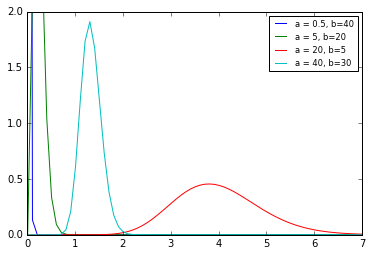

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import binom as binomial
from scipy.special import gamma
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

gdist = lambda a, b: lambda x: (b**a)*(x**(a-1))*np.exp(-b*x)/gamma(a)

X = np.arange(0.01,20,0.1)
a = [0.5,5,20,40]
b = [40,20,5,30] 
zipped = zip(a,b)
fig, ax = plt.subplots(1,1,figsize=(6,4))

for e in zipped:
    ax.plot(X,gdist(*e)(X), label = 'a = {0}, b={1}'.format(*e))
    ax.legend(loc = 'best', fontsize = 'small')
    ax.set_ylim([0,2])
    ax.set_xlim([0,7])

### Effect of Hyperparameters

As $\alpha$ increases the distribution is flattened and pushed away from zero.

As $\beta$ decreases the tails are extended.

**Exercise 2:**

The data points that you collected are in the below list denoted by waiting_time. Each of the tuples in the list represents an intervall of time that you measured. You can now use the below data points to calculate the probability of the measured intervalls as a function of $(\beta, \alpha)$

$$(\beta, \alpha) \to P_{(\beta, \alpha)}( W_1 \in [3.8,4.2), W_2 \in [3.5, 4.5), W_3 \in [4.1, 5.9), ...)$$

Create a lambda expression that maps every pair $(\beta, \alpha)$ onto the probability and craete a 3D plot. You will need to use numpy.vectorize to vectorize the lambda expression. Numpy converts the lambda expression so that it can take numpy arrays as arguments. Look into last weeks notes to find out how to plot a 3D plot.

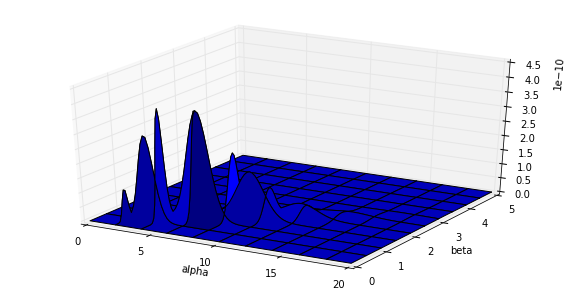

In [3]:
waiting_time =[(4,0.2),(4,0.5), (5,0.9), (6,0.2), (4,0.2), (6,0.2), (5,0.6), (15,0.6)]
waiting_range = [(x[0]-x[1],x[0]+x[1]) for x in waiting_time]

Gdist =lambda a, b: np.prod([integrate.quad(lambda x:\
                            gdist(a,b)(x),waiting_range[i][0],\
                                            waiting_range[i][1])[0] for i in range(8)])

b = np.linspace(0.01,5, 100)
a = np.linspace(0.01,20, 100)
b, a = np.meshgrid(b,a)
distvec = np.vectorize(Gdist)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1, projection = '3d')
ax1.plot_surface(a, b, distvec(a, b))
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')

**Exercise 3:**

Each of the points $(\beta, \alpha)$ represents a model that we could pick and the plot shows us how likely the measured waiting times are if we would have fixed $(\beta, \alpha)$ at the respective values. We now have to make a decision which pair $(\beta, \alpha)$ we want to pick. One way to approach this decision problem is to pick the $(\beta, \alpha)$ pair which produces the highest probability for the measured event. This approach is called **Maximum Likelihood**. 

Use the minimize function in the scipy.optimize package to find the maximum likelihood. You will have to change the function so that the maximum becomes the minimum. Additionally, minimize only takes functions of one variable. You will have to change your function so that it takes a list as an argument and not two numbers. minimize looks for a minimum around an initial point x0. You will have to provide such a point. Use method = 'Nelder-Mead'. 

See below for an example of how to use minimize.

In [4]:
from scipy.optimize import minimize

Gdist_neg = lambda ab: -Gdist(ab[0],ab[1])

X0 = [50,1]
funxMin = minimize(Gdist_neg, X0, method = 'Nelder-Mead')
funxMin.x

array([ 4.95832638,  0.81043004])

**Exercise 4:**

Now that we have our maximum likelihood solution we can take a step back and think about what we just did. 

* Take a look at the plot and remind yourself that minimize looks for a solution around an initial point x0. What's the problem with that?
* We assumed that the outcome that we measured is the outcome with the hightest probability. Take a look at the actual probability of getting what we measured under the assumption of the model. How likely was it? 
* Take a moment and check out what outliers are. How do those data points effect the solution in light of the above point and why?
* Can you think of a way to make a better decision?

1) Taking a point $X0$ too far from the actual negative, it will only reach a relative minimum instead of the actual minimum.

2) The probability density at our X0 point is just under $3x10^{-10}$. Even though this is our best guess, it is still highly unlikely.

3) Removing the outlier(s) narrows the band at which the model has to make a prediction, and should result in an increased probability of the outcome.

4) Take more data and see the real frequency of the 'outliers' to see if you can eliminate them.

**Exercise 5:**

Plot the distribution of the maximum likelihood solution together with a normed histogram of the waiting times. What can you observe and how does this relate to Exercise 4?

(array([ 0.41322314,  0.20661157,  0.10330579,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.10330579]),
 array([  3.5 ,   4.71,   5.92,   7.13,   8.34,   9.55,  10.76,  11.97,
         13.18,  14.39,  15.6 ]),
 <a list of 10 Patch objects>)

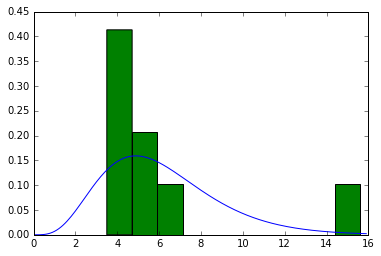

In [5]:

AA = 4.95832638
BB = 0.81043004

gdist5 = lambda x: (BB**AA)*(x**(AA-1))*np.exp(-BB*x)/gamma(AA)

w = [waiting_range[i][j] for i in range(8) for j in range(2)]

x = np.arange(0,16,0.1)
plt.plot(x,gdist5(x))
plt.hist(w, normed = True)


It shows that the outlier is throwing off the center, longer tail on the right, because the sample size is too small.

**Exercise 6:**

Calculate the Mean and the Variance of the maximum likelihood distribution using integration. Remember: The Mean of the distribution $E[W]$ is the expected waiting time and the square root of the variance $\sqrt{Var[W]}$ is the expected range of waiting times.

In [6]:
e_value = integrate.quad(lambda x: x*gdist5(x), 0, np.inf)[0]

e_var = integrate.quad(lambda x: (x**2)*gdist5(x), 0, np.inf)[0] - e_value**2

print('Mean: {0: .4f}'.format(e_value))
print('Variance: {0: .4f}'.format(e_var))

Mean:  6.1181
Variance:  7.5493


**Exercise 7:**

Use the minimize function to calculate the waiting time with the hightest probability and its respective probability. Compare your result to the result of Exercise 6. Does this make you think about a better decision methedology for $(\beta, \alpha)$?

In [7]:
gdist7 = lambda x: -gdist5(x)
X0 = [6]
funxMin = minimize(gdist7, X0, method = 'Nelder-Mead')
funxMin.x

p_x = gdist5(funxMin.x)


print('Waiting time with highest probablity density: {0: .3f}'.format(funxMin.x[0]))
print('Probability density of that waiting time: {0: .3f}'.format(p_x[0]))

Waiting time with highest probablity density:  4.884
Probability density of that waiting time:  0.159


The results show that the point with the highest probability density is to the left of the mean, telling us that the distribution is positively skewed (longer tail on the right). A look at the observed data versus the distribution shows that the one outlier at 15 minutes is the culprit for pulling out the distribution.

Pulling out a probability would require an error band, with the size of the error band being a big component of the probability.

**See below for rerunning without the outlier.** The mean is much closer to the time with the highest probability density, the probablity of that value occurring is much higher, and the variance on the distribution is smaller, giving a tighter range.



In [8]:
Gdist2 =lambda a, b: np.prod([integrate.quad(lambda x:\
                            gdist(a,b)(x),waiting_range[i][0],waiting_range[i][1])[0] for i in range(7)])

Gdist2_neg = lambda ab: -Gdist2(ab[0],ab[1])

X0 = [50,10]
funxMin = minimize(Gdist2_neg, X0, method = 'Nelder-Mead')
funxMin.x

array([ 33.54785596,   6.91515664])

(array([ 0.26455026,  0.52910053,  0.79365079,  0.52910053,  0.        ,
         0.        ,  0.        ,  0.26455026,  0.79365079,  0.52910053]),
 array([ 3.5 ,  3.77,  4.04,  4.31,  4.58,  4.85,  5.12,  5.39,  5.66,
         5.93,  6.2 ]),
 <a list of 10 Patch objects>)

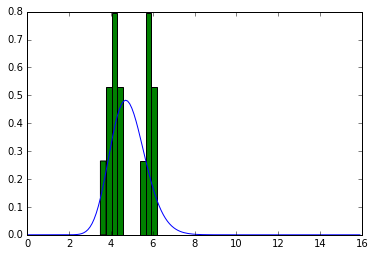

In [9]:
AA = 33.54785596
BB = 6.91515664

gdist5_2 = lambda x: (BB**AA)*(x**(AA-1))*np.exp(-BB*x)/gamma(AA)

w2 = [waiting_range[i][j] for i in range(7) for j in range(2)]

x = np.arange(0,16,0.1)
plt.plot(x,gdist5_2(x))
plt.hist(w2, normed = True)

In [10]:
e_value2 = integrate.quad(lambda x: x*gdist5_2(x), 0, np.inf)[0]

e_var2 = integrate.quad(lambda x: (x**2)*gdist5_2(x), 0, np.inf)[0] - e_value2**2

print('Mean: {0: .4f}'.format(e_value2))
print('Variance: {0: .4f}'.format(e_var2))

Mean:  4.8514
Variance:  0.7016


In [12]:
gdist7_2 = lambda x: -gdist5_2(x)
X0 = [6]
funxMin = minimize(gdist7_2, X0, method = 'Nelder-Mead')
funxMin.x

p_x2 = gdist5_2(funxMin.x)


print('Waiting time with highest probablity density: {0: .3f}'.format(funxMin.x[0]))
print('Probability density of that waiting time: {0: .3f}'.format(p_x2[0]))

Waiting time with highest probablity density:  4.707
Probability density of that waiting time:  0.482
